In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import mplfinance as mpf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

plt.rcParams['figure.dpi'] == 300
sns.set_style('whitegrid')
%matplotlib inline

In [37]:
# getting the data from yfinance
df = yf.Ticker('AAPL').history(start="2000-01-01")
df.columns = df.columns.str.lower()
df.shape

(6158, 7)

In [62]:
display(df.head(), df.tail())

,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
2000-01-03 00:00:00-05:00,0.791669,0.849227,0.767607,0.844981,535796800,0.773741,0
2000-01-04 00:00:00-05:00,0.817145,0.835073,0.763833,0.773741,512377600,0.785063,1
2000-01-05 00:00:00-05:00,0.783176,0.834601,0.777515,0.785063,778321600,0.717125,0
2000-01-06 00:00:00-05:00,0.801105,0.807709,0.717125,0.717125,767972800,0.751094,1
2000-01-07 00:00:00-05:00,0.728448,0.762417,0.720900,0.751094,460734400,0.737884,0


,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
2024-06-18 00:00:00-04:00,217.589996,218.630005,213.000000,214.289993,79943300,209.679993,0
2024-06-20 00:00:00-04:00,213.929993,214.240005,208.850006,209.679993,86172500,207.490005,0
2024-06-21 00:00:00-04:00,210.389999,211.889999,207.110001,207.490005,246421400,208.139999,1
2024-06-24 00:00:00-04:00,207.720001,212.699997,206.589996,208.139999,80727000,209.070007,1
2024-06-25 00:00:00-04:00,209.149994,211.380005,208.610001,209.070007,55549700,NaN,0


In [39]:
df.describe()

,open,high,low,close,volume,dividends,stock splits
count,6158.000000,6158.000000,6158.000000,6158.000000,6.158000e+03,6158.000000,6158.000000
mean,37.361746,37.764180,36.978993,37.386728,3.930735e+08,0.001338,0.002436
std,54.277711,54.864062,53.740127,54.323906,3.845916e+08,0.015682,0.108860
min,0.196115,0.199135,0.192039,0.198078,2.404830e+07,0.000000,0.000000
25%,1.943259,1.968395,1.906044,1.931029,1.228835e+08,0.000000,0.000000
50%,13.257717,13.363554,13.094628,13.201733,2.748368e+08,0.000000,0.000000
75%,41.143969,41.405681,40.846996,41.143619,5.267192e+08,0.000000,0.000000
max,217.589996,220.199997,213.000000,216.669998,7.421641e+09,0.250000,7.000000


### Inference of the features
- Open: The price at which the stock starts trading when the market opens.
- High: The highest price at which the stock is traded during the trading day.
- Low: The lowest price at which the stock is traded during the trading day.
- Close: The price at which the stock stops trading when the market closes.
- Volume: The total number of shares traded during the trading day.
- Dividends: Payments made to shareholders, usually from company profits, typically on a per-share basis.
- Stock Splits: An adjustment in the number of a company’s shares, either increasing (split) or decreasing (reverse split) the number of shares, without changing the company's total market value.

## Plotting the line plot for each feature

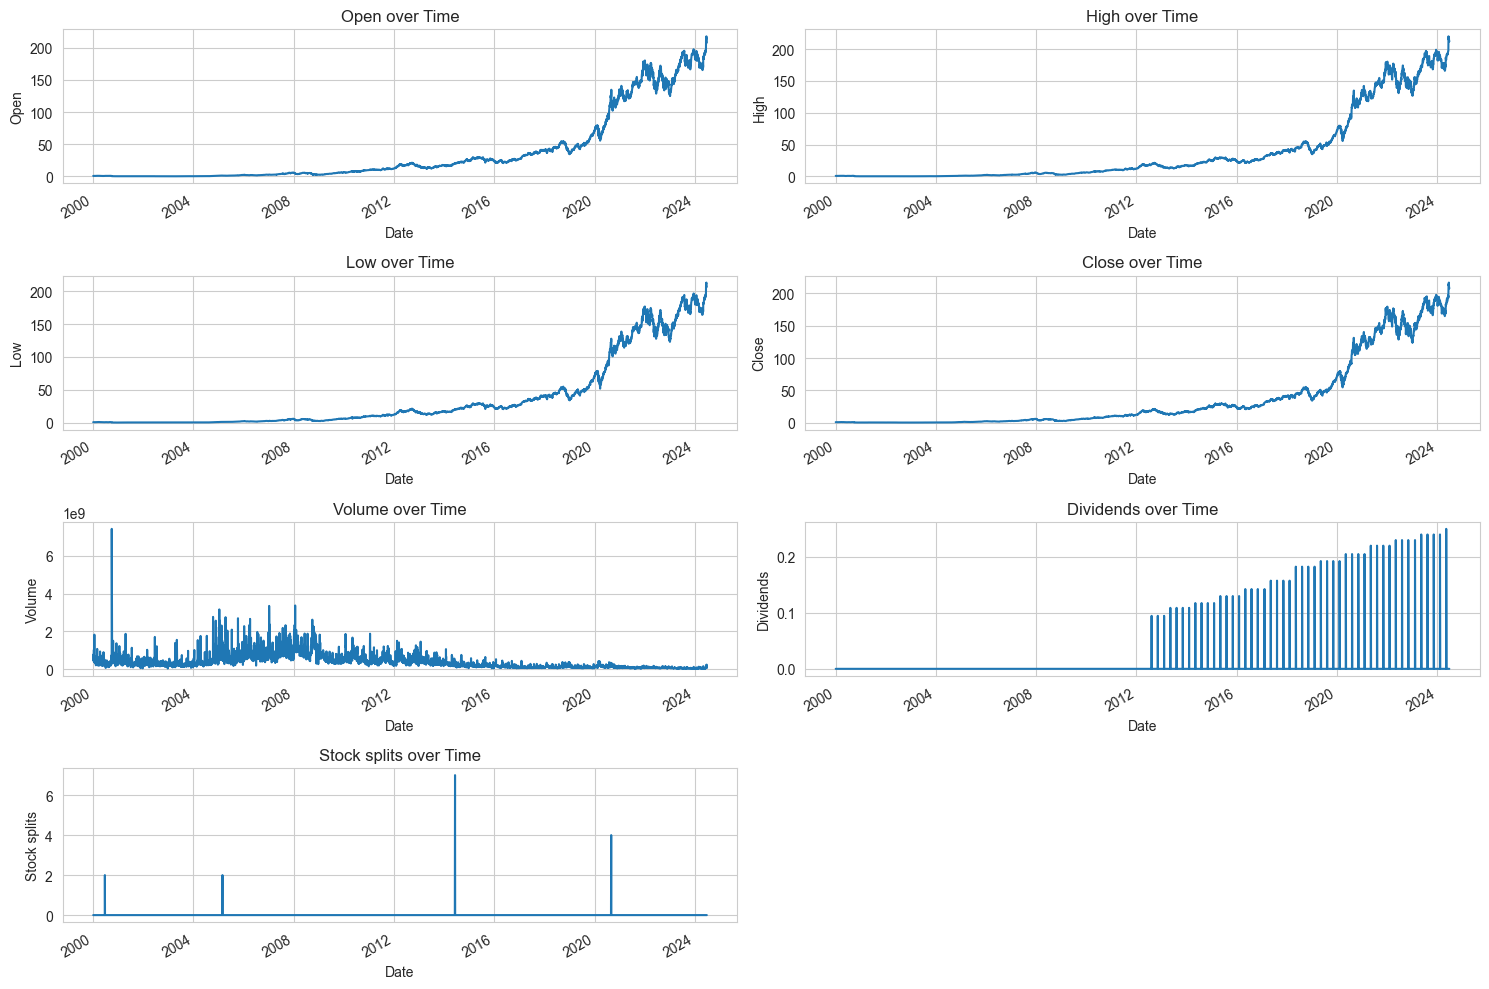

In [24]:
columns = df.describe().columns.to_list()

n_cols = 2
n_rows = (len(columns) + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten() 

for i, column in enumerate(columns):
    df[column].plot(ax=axes[i])
    axes[i].set_title(f'{column.capitalize()} over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column.capitalize())

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- For the `Open`, `Close`, `Low` and `High` the trends are showing an upward trend
- `Volume` had more variance __before 2016__ and since then it has been not that varied
- `Dividends` started after after the __start of 2012__ and has been growing consistently

## Plotting histograms for each metric

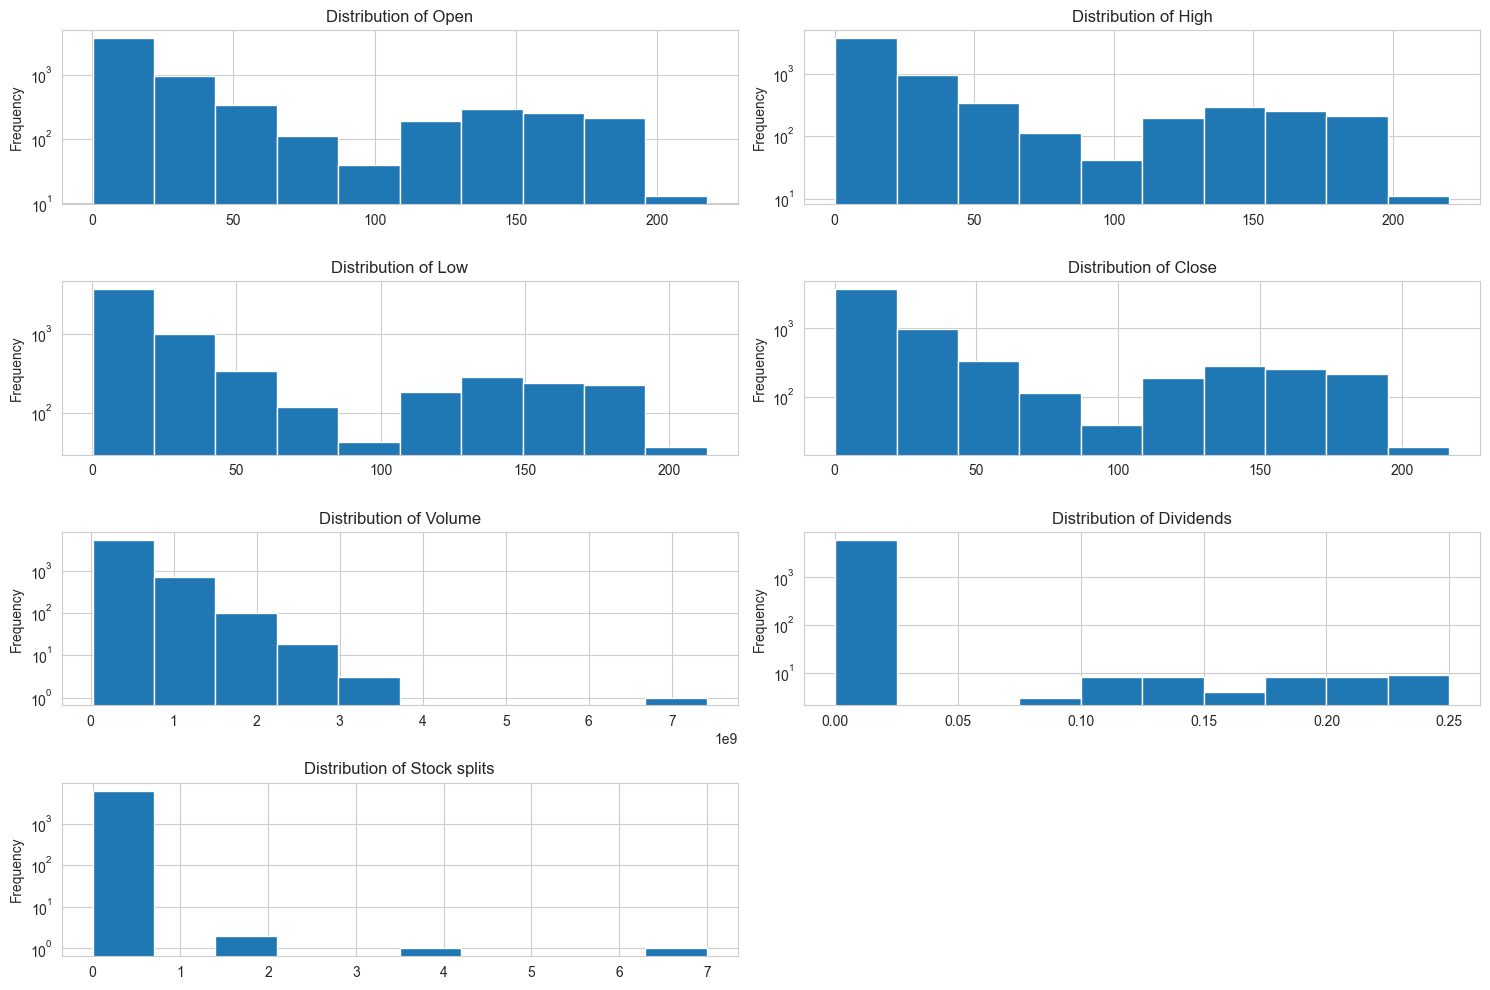

In [8]:
columns = df.describe().columns.to_list()

n_cols = 2
n_rows = (len(columns) + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten() 

for i, column in enumerate(columns):
    df[column].plot(kind='hist', ax=axes[i])
    axes[i].set_title(f'Distribution of {column.capitalize()}')
    axes[i].set_yscale('log')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Once again the distribution of `Open`, `Close`, `Low` and `High` are very similiar to each other.
- The volume appears to be right skewed with no values in __4,5 and 6 bins__

## Candle Stick Chart

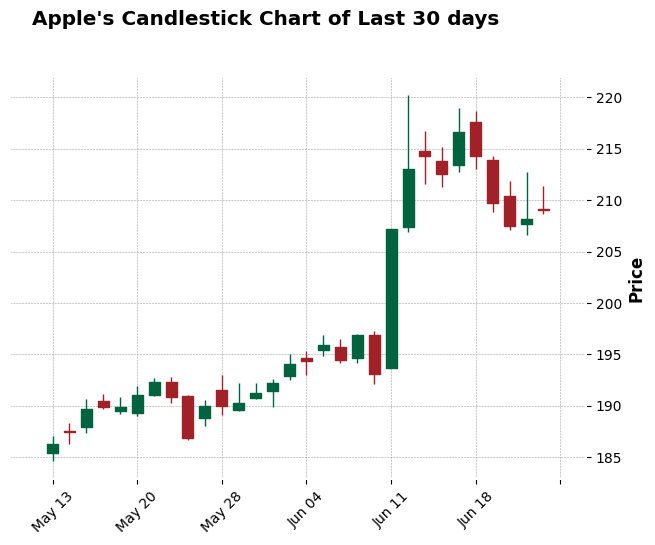

In [24]:
mpf.plot(df[-30:], type='candle', style='charles', title="Apple's Candlestick Chart of Last 30 days", ylabel='Price')

## Correlation heatmap plot

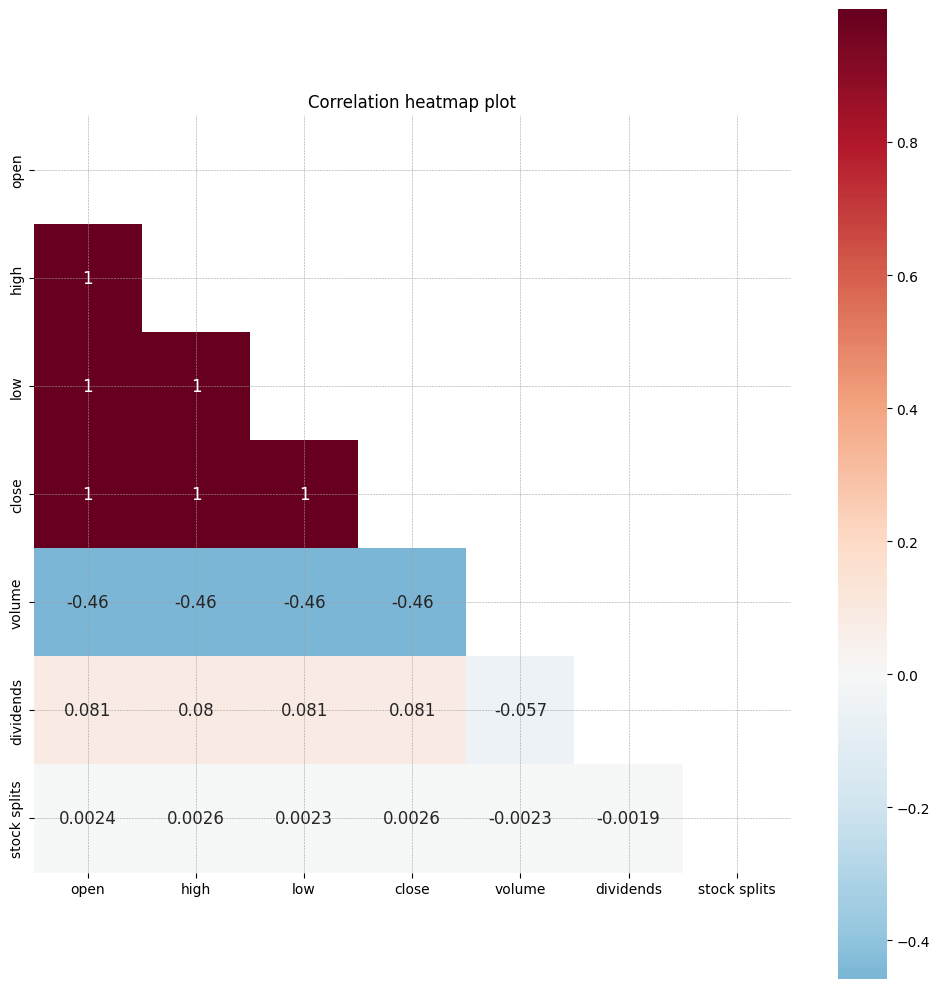

In [29]:
# Creating a heatmap correlation plot
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), mask=mask, cmap='RdBu_r', annot=True, 
            center=0, square=True, annot_kws={'size':12})
plt.title("Correlation heatmap plot")
plt.tight_layout()
plt.show()

In [40]:
# dropping dividend and stock split as we won't be needing them to predict the stock trend
df.shape
df = df.drop(columns=['dividends','stock splits'])
df.shape

(6158, 5)

In [41]:
df.sample(5)

,open,high,low,close,volume
Date,,,,,
2012-06-07 00:00:00-04:00,17.431126,17.432031,17.226104,17.262941,379766800
2010-03-02 00:00:00-05:00,6.338783,6.365958,6.272656,6.306173,566546400
2005-04-01 00:00:00-05:00,1.270896,1.273614,1.225001,1.234663,641284000
2012-06-13 00:00:00-04:00,17.347486,17.467056,17.222479,17.276226,293580000
2016-12-08 00:00:00-05:00,25.725159,26.089479,25.664825,26.017544,108273200


## Feature Engineering

In [42]:
# creating a column that stores the value of the closing price of the next day
df['tomorrow'] = df['close'].shift(-1)
df.head()

,open,high,low,close,volume,tomorrow
Date,,,,,,
2000-01-03 00:00:00-05:00,0.791669,0.849227,0.767607,0.844981,535796800,0.773741
2000-01-04 00:00:00-05:00,0.817145,0.835073,0.763833,0.773741,512377600,0.785063
2000-01-05 00:00:00-05:00,0.783176,0.834601,0.777515,0.785063,778321600,0.717125
2000-01-06 00:00:00-05:00,0.801105,0.807709,0.717125,0.717125,767972800,0.751094
2000-01-07 00:00:00-05:00,0.728448,0.762417,0.720900,0.751094,460734400,0.737884


In [43]:
# creating a flag column that checks of the tomorrow price is greater than today (i.e. upwards trend) as 1 else (i.e. downwards trend) as 0
df['target'] = np.where(df['tomorrow'] > df['close'], 1, 0)
df.sample(5)

,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
2002-07-25 00:00:00-04:00,0.225404,0.225705,0.211514,0.216799,479354400,0.216496,0
2020-08-06 00:00:00-04:00,107.823183,111.736967,107.229891,111.238892,202428800,108.709816,0
2000-11-02 00:00:00-05:00,0.318932,0.338748,0.317988,0.336861,590693600,0.335916,0
2012-02-10 00:00:00-05:00,14.824412,15.025508,14.751641,14.898690,631302000,15.175875,1
2021-02-04 00:00:00-05:00,133.582704,134.660766,131.906789,134.650970,84183100,134.233841,0


## Model Training

In [102]:
# splitting the data into train and test sets
train = df.iloc[:-100]
test = df.iloc[-100:]
assert train.shape[0] + test.shape[0] == df.shape[0]
assert train.index.intersection(test.index).empty == True

In [83]:
display(train.tail(), test.tail())
print(f"Shape of training data: {train.shape}\nShape of testing data: {test.shape}")

,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
2024-01-25 00:00:00-05:00,194.707126,195.754371,192.602669,193.659882,54822100,191.914474,0
2024-01-26 00:00:00-05:00,193.759620,194.248323,191.435740,191.914474,44594000,191.226273,0
2024-01-29 00:00:00-05:00,191.505536,191.695039,189.081927,191.226273,47145600,187.545975,0
2024-01-30 00:00:00-05:00,190.438365,191.296106,186.977480,187.545975,55859400,183.915543,0
2024-01-31 00:00:00-05:00,186.548606,186.608461,183.865686,183.915543,55467800,186.369095,1


,open,high,low,close,volume,tomorrow,target
Date,,,,,,,
2024-06-18 00:00:00-04:00,217.589996,218.630005,213.000000,214.289993,79943300,209.679993,0
2024-06-20 00:00:00-04:00,213.929993,214.240005,208.850006,209.679993,86172500,207.490005,0
2024-06-21 00:00:00-04:00,210.389999,211.889999,207.110001,207.490005,246421400,208.139999,1
2024-06-24 00:00:00-04:00,207.720001,212.699997,206.589996,208.139999,80727000,209.070007,1
2024-06-25 00:00:00-04:00,209.149994,211.380005,208.610001,209.070007,55549700,NaN,0


Shape of training data: (6058, 7)
Shape of testing data: (100, 7)


In [103]:
# picking the features we want to use
predictors = ['open', 'close', 'high', 'low', 'volume']

# fitting the model
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)
model.fit(train[predictors], train['target'])